In [247]:
#import MEDYANSimRunner
using MEDYAN
using MEDYANVis
using StaticArrays
using LinearAlgebra
using Random
using Setfield
using OrderedCollections: OrderedDict
using SmallZarrGroups
using CairoMakie
Random.seed!(1234);

In [248]:
agent_names = MEDYAN.AgentNames(;
    diffusingspeciesnames=[
        :GA, # G-Actin with no bound nucleotide
        :GAD, # G-Actin in the ADP form
        :GADPi, # G-Actin in the ADP Pi form
        :GAT, # G-Actin in the ATP form
    ],
    filamentnames=[
        (:actin, [
            # Monomer states
            :FAD, # F-Actin in the ADP form
            :FADPi, # F-Actin in the ADP Pi form
            :FAT, # F-Actin in the ATP form
            :BarbedD, # Barbed end in the ADP form
            :BarbedDPi, # Barbed end in the ADP Pi form
            :BarbedT, # Barbed end in the ATP form
            :PointedD, # Pointed end in the ADP form
            :PointedDPi, # Pointed end in the ADP Pi form
            :PointedT, # Pointed end in the ATP form
        ])
    ]
)

MEDYAN.AgentNames([:GA, :GAD, :GADPi, :GAT], Symbol[], Symbol[], Symbol[], [(:actin, [:FAD, :FADPi, :FAT, :BarbedD, :BarbedDPi, :BarbedT, :PointedD, :PointedDPi, :PointedT])], Symbol[], Symbol[], Symbol[])

In [249]:
s = MEDYAN.SysDef(agent_names)

MEDYAN.SysDef
 Diffusing species:
  GA: 0.0 nm²/s
  GAD: 0.0 nm²/s
  GADPi: 0.0 nm²/s
  GAT: 0.0 nm²/s
 Filaments:
  actin:
   monomer states: [:FAD, :FADPi, :FAT, :BarbedD, :BarbedDPi, :BarbedT, :PointedD, :PointedDPi, :PointedT]
   params: MEDYAN.FilamentMechParams(NaN, NaN, NaN, NaN, -1, -1)


In [250]:
DGActin = 5E6
for name in keys(s.diffusing)
    add_diffusion_coeff!(s, name, DGActin) # nm²/s
end

In [251]:
add_filament_params!(s, :actin, MEDYAN.ACTIN_FIL_PARAMS)

MEDYAN.SysDef
 Diffusing species:
  GA: 5.0e6 nm²/s
  GAD: 5.0e6 nm²/s
  GADPi: 5.0e6 nm²/s
  GAT: 5.0e6 nm²/s
 Filaments:
  actin:
   monomer states: [:FAD, :FADPi, :FAT, :BarbedD, :BarbedDPi, :BarbedT, :PointedD, :PointedDPi, :PointedT]
   params: MEDYAN.FilamentMechParams(3.0, 2.7, 4000.0, 26880.0, 40, 1)


In [252]:
# Assume ATP, Pi, and ADP concentrations are fixed
ATP = 10000.0 * MEDYAN.μM⁻¹_per_nm³
Pi = 2000.0 * MEDYAN.μM⁻¹_per_nm³
ADP = 2000.0 * MEDYAN.μM⁻¹_per_nm³
KfGATPoint  = 0.0/MEDYAN.μM⁻¹_per_nm³
KrGATPoint  = 10.0
KfGADPoint  = 0.0/MEDYAN.μM⁻¹_per_nm³
KrGADPoint  = 10.0
KfGATBarb   = 10.0/MEDYAN.μM⁻¹_per_nm³
KrGATBarb   = 0.0
KfGADBarb   = 10.0/MEDYAN.μM⁻¹_per_nm³
KrGADBarb   = 0.0
KfPiRelease = 0.0026
KrPiRelease = 5.20E-6/MEDYAN.μM⁻¹_per_nm³

# 100
addreaction!(s,
    "diffusing.GADPi --> diffusing.GAD",
    0.0312,
    0,
)
addreaction!(s,
    "diffusing.GAD --> diffusing.GADPi",
    KrPiRelease*Pi,
    0,
)

# 104
addreaction!(s,
    "diffusing.GA --> diffusing.GAT",
    1.7/MEDYAN.μM⁻¹_per_nm³*ATP,
    0,
)
addreaction!(s,
    "diffusing.GAT --> diffusing.GA",
    0.011,
    0,
)

# 109
addreaction!(s,
    "diffusing.GA --> diffusing.GAD",
    0.9/MEDYAN.μM⁻¹_per_nm³*ADP,
    0,
)
addreaction!(s,
    "diffusing.GAD --> diffusing.GA",
    0.071,
    0,
)

MEDYAN.SysDef
 Diffusing species:
  GA: 5.0e6 nm²/s
  GAD: 5.0e6 nm²/s
  GADPi: 5.0e6 nm²/s
  GAT: 5.0e6 nm²/s
 Filaments:
  actin:
   monomer states: [:FAD, :FADPi, :FAT, :BarbedD, :BarbedDPi, :BarbedT, :PointedD, :PointedDPi, :PointedT]
   params: MEDYAN.FilamentMechParams(3.0, 2.7, 4000.0, 26880.0, 40, 1)
 Compartment reactions without callbacks:
  "diffusing.GADPi --> diffusing.GAD" 0.0312 1/s
  "diffusing.GAD --> diffusing.GADPi" 0.0104 1/s
  "diffusing.GA --> diffusing.GAT" 17000.0 1/s
  "diffusing.GAT --> diffusing.GA" 0.011 1/s
  "diffusing.GA --> diffusing.GAD" 1799.9999999999998 1/s
  "diffusing.GAD --> diffusing.GA" 0.071 1/s


In [253]:
monomerspacing=2.7 # nm


nucleotide_states = ("T", "DPi", "D")

# Barbed end polymerization and depolymerization
barbed_rates = [
    ("T", KfGATBarb, KrGATBarb),
    ("DPi", KfGATBarb, KrGATBarb),
    ("D", KfGADBarb, KrGADBarb),
]
for (new_nuc, forward_rate, reverse_rate) in barbed_rates
    for base_nuc in nucleotide_states
        addfilamentend_reaction!(s,
            :actin,
            Symbol("f", "GA", new_nuc, "_to_Barbed", base_nuc),
            false,
            [Symbol("Barbed", base_nuc)]=>[Symbol("FA", base_nuc), Symbol("Barbed", new_nuc)],
            monomerspacing,
            "diffusing.GA"*new_nuc*" -->",
            forward_rate,
            1,
        )
        addfilamentend_reaction!(s,
            :actin,
            Symbol("r", "GA", new_nuc, "_to_Barbed", base_nuc),
            false,
            [Symbol("FA", base_nuc), Symbol("Barbed", new_nuc)]=>[Symbol("Barbed", base_nuc)],
            0.0,
            "--> diffusing.GA"*new_nuc,
            reverse_rate,
            0,
        )
    end
end

# Pointed end polymerization and depolymerization
pointed_rates = [
    ("T", KfGATPoint, KrGATPoint),
    ("DPi", KfGATPoint, KrGATPoint),
    ("D", KfGADPoint, KrGADPoint),
]
for (new_nuc, forward_rate, reverse_rate) in pointed_rates
    for base_nuc in nucleotide_states
        addfilamentend_reaction!(s,
            :actin,
            Symbol("f", "GA", new_nuc, "_to_Pointed", base_nuc),
            true,
            [Symbol("Pointed", base_nuc)]=>[Symbol("Pointed", new_nuc), Symbol("FA", base_nuc)],
            monomerspacing,
            "diffusing.GA"*new_nuc*" -->",
            forward_rate,
            1,
        )
        addfilamentend_reaction!(s,
            :actin,
            Symbol("r", "GA", new_nuc, "_to_Pointed", base_nuc),
            true,
            [Symbol("Pointed", new_nuc), Symbol("FA", base_nuc)]=>[Symbol("Pointed", base_nuc)],
            0.0,
            "--> diffusing.GA"*new_nuc,
            reverse_rate,
            0,
        )
    end
end

# Filament ATP hydrolysis and Pi Dissociation
for monomer_state in ("FA", "Barbed", "Pointed")
    addfilament_reaction!(s,
        :actin,
        Symbol(monomer_state, "T_to_", monomer_state, "DPi"),
        [Symbol(monomer_state, "T")]=>[Symbol(monomer_state, "DPi")],
        1,
        "-->",
        0.3,
        0,
    )
    addfilament_reaction!(s,
        :actin,
        Symbol(monomer_state, "DPi_to_", monomer_state, "D"),
        [Symbol(monomer_state, "DPi")]=>[Symbol(monomer_state, "D")],
        1,
        "-->",
        KfPiRelease,
        0,
    )
    addfilament_reaction!(s,
        :actin,
        Symbol(monomer_state, "D_to_", monomer_state, "DPi"),
        [Symbol(monomer_state, "D")]=>[Symbol(monomer_state, "DPi")],
        1,
        "-->",
        KrPiRelease*Pi,
        0,
    )
end
s

MEDYAN.SysDef
 Diffusing species:
  GA: 5.0e6 nm²/s
  GAD: 5.0e6 nm²/s
  GADPi: 5.0e6 nm²/s
  GAT: 5.0e6 nm²/s
 Filaments:
  actin:
   monomer states: [:FAD, :FADPi, :FAT, :BarbedD, :BarbedDPi, :BarbedT, :PointedD, :PointedDPi, :PointedT]
   params: MEDYAN.FilamentMechParams(3.0, 2.7, 4000.0, 26880.0, 40, 1)
   filament sites:
    FAT_to_FADPi: MEDYAN.FilamentSiteGeneral(1, UInt8[0x03])
    FADPi_to_FAD: MEDYAN.FilamentSiteGeneral(1, UInt8[0x02])
    FAD_to_FADPi: MEDYAN.FilamentSiteGeneral(1, UInt8[0x01])
    BarbedT_to_BarbedDPi: MEDYAN.FilamentSiteGeneral(1, UInt8[0x06])
    BarbedDPi_to_BarbedD: MEDYAN.FilamentSiteGeneral(1, UInt8[0x05])
    BarbedD_to_BarbedDPi: MEDYAN.FilamentSiteGeneral(1, UInt8[0x04])
    PointedT_to_PointedDPi: MEDYAN.FilamentSiteGeneral(1, UInt8[0x09])
    PointedDPi_to_PointedD: MEDYAN.FilamentSiteGeneral(1, UInt8[0x08])
    PointedD_to_PointedDPi: MEDYAN.FilamentSiteGeneral(1, UInt8[0x07])
   filament end sites:
    fGAT_to_BarbedT: MEDYAN.FilamentEndSiteGe

In [255]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

"""
Calculates the center of mass velocity of the network.
"""
function vel_com_cell(c,drmon,rmon_old)
    n_cell = MArray{Tuple{prod(c.grid.n)},Int64}(zeros(prod(c.grid.n)))
    dra_x_cell = MArray{Tuple{prod(c.grid.n)},Float64}(zeros(prod(c.grid.n)))
    dra_y_cell = MArray{Tuple{prod(c.grid.n)},Float64}(zeros(prod(c.grid.n)))
    dra_z_cell = MArray{Tuple{prod(c.grid.n)},Float64}(zeros(prod(c.grid.n)))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        n_cell[cid] += 1
        dra_x_cell[cid] += view(drmon,i)[1][1]
        dra_y_cell[cid] += view(drmon,i)[1][2]
        dra_z_cell[cid] += view(drmon,i)[1][3]  
    end
    va_x_cell = dra_x_cell./n_cell
    va_y_cell = dra_y_cell./n_cell
    va_z_cell = dra_z_cell./n_cell
    return va_x_cell,va_y_cell,va_z_cell
end

"""
Calculates the porosity field.
"""
function calc_por_cell(c,rmon_old)
    #estimate actin monomer volume by assume it is a sphere with radius 3.5 nm
    actin_rad = 3.5
    actin_vol = (4/3)*π*(actin_rad^3)
    por_cell = MArray{Tuple{prod(c.grid.n)},Float64}(zeros(prod(c.grid.n)))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        por_cell[cid] += 1
    end
    por_cell *= actin_vol/((c.grid.compartmentsize)^3)
    return por_cell
end

"""
Calculates the hydrolic permiability from porosity, using Gebart's formula.
"""
function calc_hydro_perm_cell_G(por_cell)
    #filament diameter in nm
    d = 7.0
    #fitting parameters
    ϕc = 0.0743 
    C1 = 0.491
    C2 = 2.31
    perm_cell = map(x -> (d^2)*C1*(sqrt((1-ϕc)/(1-x))-1)^C2, por_cell)
    return perm_cell
end

"""
Calculates the hydrolic permiability from porosity, using Kozeny and Carman's formula.
"""
function calc_hydro_perm_cell_KC(por_cell)
    #filament diameter in nm
    d = 7.0
    perm_cell = map(x -> inv(180)*(d^2)*(x^3)/((1-x)^2), por_cell)
    return perm_cell
end

calc_hydro_perm_cell_KC

In [277]:
vis = Visualizer()
setvisible!(vis["/Grid"], false)
setvisible!(vis["/Axes"], false)
setvisible!(vis["/Background"], false)

[ Info: Listening on: 127.0.0.1:8717, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8717


MeshCat Visualizer with path /Background at http://127.0.0.1:8717

In [282]:
#system parameters
Lx = 1
Ly = 1
Lz = 3
lcell = 500
nsec = 10
dt = 0.01

0.01

In [283]:
#set up system and run for nsec seconds
nsubstep = Int(inv(dt))

grid = CubicGrid((Lx,Ly,Lz),lcell)

c = MEDYAN.Context(s, grid)

set_mechboundary!(c, MEDYAN.boundary_box(grid; stiffness=100.0))

adddiffusingcount_rand!(c, s.diffusing.GAT, 700)

monomerstates = [s.state.actin.PointedD, s.state.actin.FADPi, s.state.actin.FAT, s.state.actin.BarbedT]
nodepositions = [
    SA[0.0,0.0,0.0], 
    SA[0.0,0.0,monomerspacing*length(monomerstates)]
]
chem_newfilament!(c; monomerstates, nodepositions, node_mids=[1,])

for i in 1:nsec
    for j in 1:nsubstep
        run_chemistry!(c,dt)
        
        #get n-1-th minimized state
        rmon_old = calc_rmon(c)
        
        #get n-th minimized state
        minimize_energy!(c)
        rmon_new = calc_rmon(c)
        drmon = rmon_new .- rmon_old
        
        #calculate the network velocity
        va_x_cell, va_y_cell, va_z_cell = vel_com_cell(c,drmon,rmon_old)
        #calculate the porosity field
        por_cell = calc_por_cell(c,rmon_old)
        #calculate the hydrolic permiability tensor element
        perm_cell = calc_hydro_perm_cell_KC(por_cell)
    
        draw_context!(vis, c, s)
    end
end

LoadError: InterruptException:

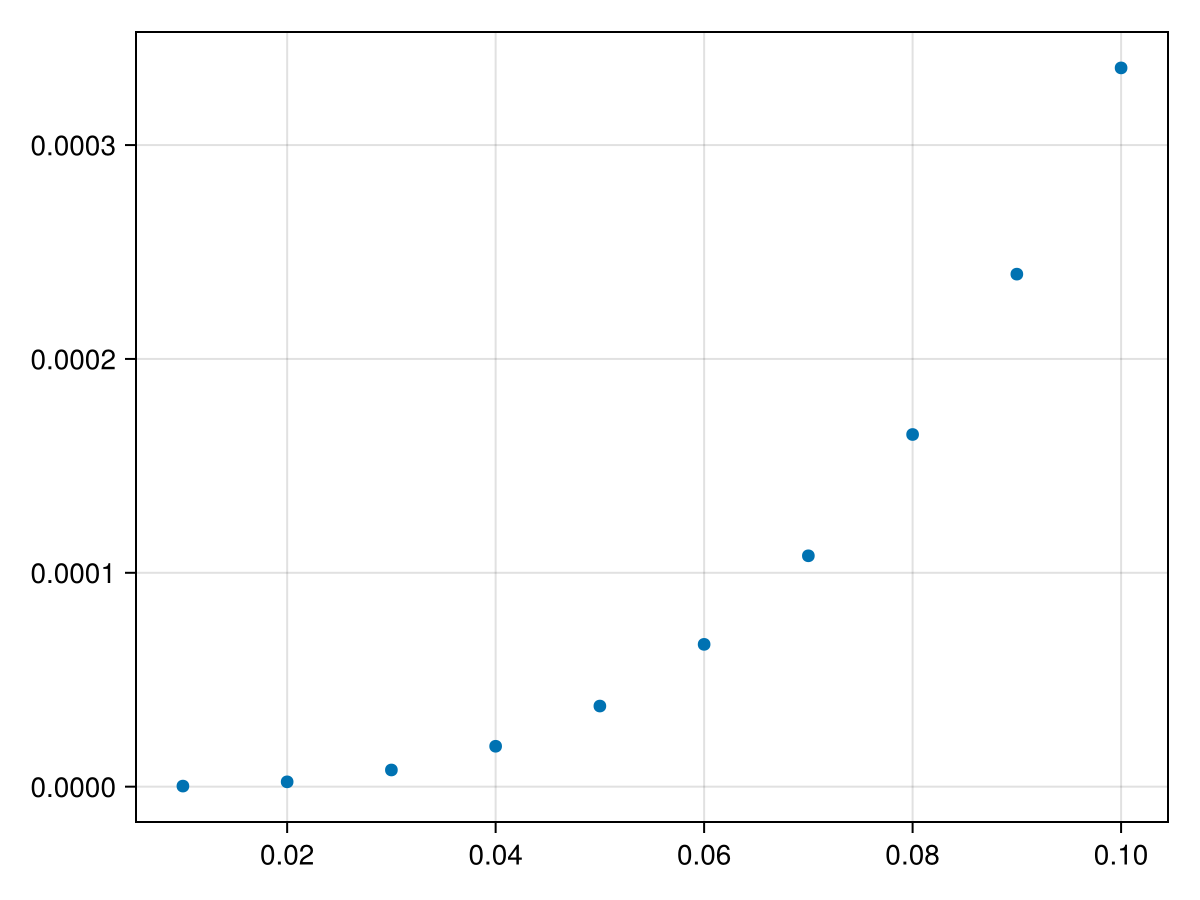

In [221]:
xarr = range(0.01,0.1,step=0.01)
yarr1 = calc_hydro_perm_cell_KC(xarr)
#yarr2 = calc_hydro_perm_cell_G(xarr)
scatter(xarr,yarr1)

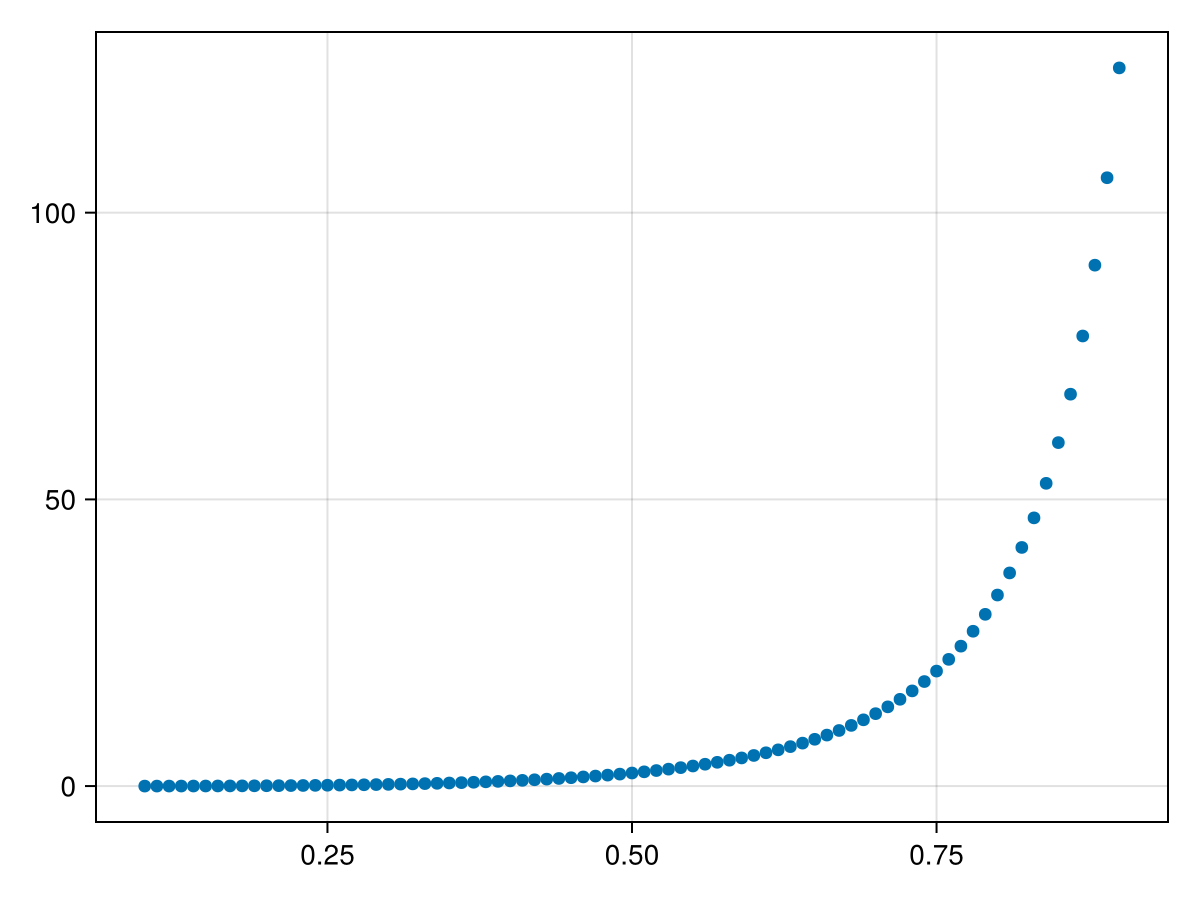

In [219]:
scatter(xarr,yarr2)

In [134]:
actin_rad = 3.5
actin_vol = (4/3)*π*(actin_rad^3)
println(actin_vol/((c.grid.compartmentsize)^3))

1.4367550402417319e-6


In [195]:
calc_hydro_perm_cell(0.074300000001)

1.104410027286886e-27

In [147]:
Lx = 1
Ly = 1
Lz = 3

grid = CubicGrid((Lx,Ly,Lz),500.0)
c = MEDYAN.Context(s, grid)
println(c.grid.n)
println(Tuple{prod(c.grid.n)})

MArray{Tuple{prod(c.grid.n)},Int64}(zeros(prod(c.grid.n)))
#MArray{Tuple{L^3},Float64}(zeros(L^3))

[1, 1, 3]
Tuple{3}


3-element MVector{3, Int64} with indices SOneTo(3):
 0
 0
 0

In [98]:
#set up system and run
nsec = 10
header,c,s = setup(jobs[1])
lcell = 500

for i in 1:nsec
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        
        #get n-1-th minimized state
        rmon_old = calc_rmon(c)
        
        #get n-th minimized state
        MEDYAN.minimize_energy!(c)
        #rmon_new = calc_rmon(c)
        #drmon = rmon_new .- rmon_old
        
        #calculate the network velocity
        #va_x_cell, va_y_cell, va_z_cell = vel_com_cell(c,drmon,rmon_old)
        #calculate the porosity field
        #por_cell = calc_por_cell(c,rmon_old,lcell)
        #calculate the hydrolic permiability tensor element
        #perm_cell = calc_hydro_perm_cell(por_cell)
        #println(perm_cell)
        
        draw_context!(vis, c, s)
        sleep(0.02)
    end
end

LoadError: UndefVarError: `jobs` not defined

In [13]:
#L = 3
grid = CubicGrid((1,1,3),500.0)

c = MEDYAN.Context(s, grid)

set_mechboundary!(c, MEDYAN.boundary_box(grid; stiffness=100.0))

adddiffusingcount_rand!(c, s.diffusing.GAT, 700)

monomerstates = [s.state.actin.PointedD, s.state.actin.FADPi, s.state.actin.FAT, s.state.actin.BarbedT]
nodepositions = [
    SA[0.0,0.0,0.0], 
    SA[0.0,0.0,monomerspacing*length(monomerstates)]
]
chem_newfilament!(c; monomerstates, nodepositions, node_mids=[1,])

1

In [14]:
"Simulation cube length in 500 nm segments."
const L = 1

"Number of steps to take."
const NSTEPS = 1000

jobs = ["1", "2", "3",]

"""
Return the header_dict and context.
"""
function setup(job::String; kwargs...)
    agentnames = MEDYAN.AgentNames(
        diffusingspeciesnames= [:a,:cl,:m],
        filamentnames= [(:actin,[
                                :plusend,
                                :minusend,
                                :middle,
                                :bound,
                            ]),
        ],
        link_2mon_names= [
            :motor,
            :crosslinker,
        ]
    )
    grid = CubicGrid((L,L,L),500.0)
    monomerspacing = MEDYAN.ACTIN_FIL_PARAMS.spacing
    begin
        s= MEDYAN.SysDef(agentnames)

        add_diffusion_coeff!(s, :a, 20E6)
        add_diffusion_coeff!(s, :cl, 2.0E6)
        add_diffusion_coeff!(s, :m, 0.2E6)

        add_filament_params!(s, 
            :actin,
            MEDYAN.ACTIN_FIL_PARAMS,
        )

        add_link_2mon!(s,
            :motor,
            Link2MonState((numHeads=20,),(L0=NaN,)),
            MEDYAN.DistanceRestraintMechParams(k=55.0),
        )
        
        add_link_2mon!(s,
            :crosslinker,
            Link2MonState((;),(L0=NaN,)),
            MEDYAN.DistanceRestraintMechParams(k=8.0),
        )
        
        #plus end polymerization
        addfilamentend_reaction!(s, :actin, :pp, false,
            [:plusend]=>[:middle,:plusend], monomerspacing,
            "diffusing.a -->", 0.154*500^3, 1,
        )
        #plus end depolymerization
        addfilamentend_reaction!(s, :actin, :dpp, false,
            [:middle,:plusend]=>[:plusend], 0.0,
            "--> diffusing.a", 1.4, 0,
        )

        #minus end polymerization
        addfilamentend_reaction!(s, :actin, :mp, true,
            [:minusend]=>[:minusend,:middle], monomerspacing,
            "diffusing.a -->", 0.0173*500^3, 1,
        )
        #minus end depolymerization
        addfilamentend_reaction!(s, :actin, :dmp, true,
            [:minusend,:middle]=>[:minusend], 0.0,
            "--> diffusing.a", 0.8, 0,
        )

        motorstepsize = 10

        #motor binding
        site = MEDYAN.Decimated2MonSiteMinAngleRange(
            s.filament.actin,
            s.filament.actin,
            motorstepsize,
            motorstepsize,
            s.state.actin.middle,
            s.state.actin.middle,
            175.0,
            225.0,
            cos(5*π/180),
        )
        add_decimated_2mon_site!(s,:motorbinding,site)
        bindcallback = MEDYAN.SimpleMotorBindCallback(
            s.decimated_2mon_site.motorbinding.id,
            s.link_2mon.motor,
            30, #max number of heads
            15, #min number of heads
            s.state.actin.bound,
            [s.diffusing.m=>-1],
        )
        addreactioncallback!(
            s,
            "decimated_2mon_site.motorbinding + diffusing.m",
            0.2*22*500^3/2,
            1,
            bindcallback,
        )

        #motor unbinding
        site = MEDYAN.Link2MonSiteMotorCatch()
        addunbindinglink_2mon_site!(s, 
            :motor, :unbinding, site,
            :actin, :middle, :actin, :middle,
            "--> diffusing.m", 1.0, 0, 
        )

        #motor stepping
        onrate = 0.2
        offrate = 1.7
        dutyratio = onrate/(onrate+offrate)
        site1 = MEDYAN.Link2MonSiteMotorStall(
            fs = 90.0,
            k0 = 6.0/(108/4)*((1 - dutyratio) / dutyratio) * onrate,
            isminusend = true,
        )
        site2 = @set site1.isminusend = false
        add_link_2mon_site!(s,:motor,:motorstepminus,site1)
        add_link_2mon_site!(s,:motor,:motorstepplus,site2)
        stepcallback1 = MEDYAN.SimpleMotorStepCallback(
            lsid = s.link_2mon_site.motor.motorstepminus.id,
            ltid = s.link_2mon.motor,
            unboundstate = s.state.actin.middle,
            boundstate = s.state.actin.bound,
            stepsize = motorstepsize,
        )
        stepcallback2 = @set stepcallback1.lsid = s.link_2mon_site.motor.motorstepplus.id
        addreactioncallback!(
            s,
            "link_2mon_site.motor.motorstepminus",
            1.0,
            0,
            stepcallback1,
        )
        addreactioncallback!(
            s,
            "link_2mon_site.motor.motorstepplus",
            1.0,
            0,
            stepcallback2,
        )

        #crosslinker binding site
        site = MEDYAN.Decimated2MonSiteMinAngleRange(
            s.filament.actin,
            s.filament.actin,
            10,
            10,
            s.state.actin.middle,
            s.state.actin.middle,
            30.0,
            40.0,
            cos(5*π/180)
        )
        add_decimated_2mon_site!(s,:crosslinkbinding,site)
        sitecallback = MEDYAN.SimpleCrosslinkBindCallback(
            s.decimated_2mon_site.crosslinkbinding.id,
            s.link_2mon.crosslinker,
            s.state.actin.bound,
            [s.diffusing.cl=>-1],
        )
        addreactioncallback!(s,
            "decimated_2mon_site.crosslinkbinding + diffusing.cl",
            0.01*500^3/2,
            1,
            sitecallback,
        )

        #crosslinker unbinding
        site = MEDYAN.Link2MonSiteSlipBond(f0 = inv(0.24*MEDYAN.default_β) , k0 = 0.3)
        addunbindinglink_2mon_site!(s, 
            :crosslinker, :unbinding, site,
            :actin, :middle, :actin, :middle,
            "--> diffusing.cl", 1.0, 0, 
        )
    end
    begin
        NMonomers= 40
        monomerstates= zeros(UInt8,NMonomers)
        monomerstates[1:end] .= s.state.actin.middle
        monomerstates[1] = s.state.actin.minusend
        monomerstates[end] = s.state.actin.plusend
    end
    begin
        c= MEDYAN.Context(s,grid;
            g_tol=1.0,
            max_cylinder_force = 1000.0,
            maxstep = 0.7,
        )
        set_mechboundary!(c, MEDYAN.boundary_box(grid; stiffness=100.0))
        adddiffusingcount_rand!(c, s.diffusing.a, 625*L^3)
        adddiffusingcount_rand!(c, s.diffusing.cl, 63*L^3)
        adddiffusingcount_rand!(c, s.diffusing.m, 6*L^3)
        for i in 1:(7*L^3)
            newfilament_rand!(c::MEDYAN.Context, monomerstates)
            MEDYAN.minimize_energy!(c)
        end
    end
    header = OrderedDict([
        "medyan"=>MEDYAN.header(c),
    ])
    return header, c, s
end

"""
Save the context into a group
"""
function save(step::Int, c::MEDYAN.Context; kwargs...)::ZGroup
    group = ZGroup()
    group["medyan"] = MEDYAN.snapshot(c;
        filament_position_scale=5,
        membrane_position_scale=5,
    )
    group
end

"""
Load the context from a group
"""
function load(step::Int, group::ZGroup, c; kwargs...)
    MEDYAN.load_snapshot!(c, group["medyan"]::ZGroup)
    c
end

function done(step::Int, c)
    step ≥ NSTEPS, NSTEPS
end

"""
Move the simulation forward one second in time.
"""
function loop(step::Int, c; kwargs...)
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        MEDYAN.minimize_energy!(c)
    end
    c
end

loop

In [8]:
vis = Visualizer()
setvisible!(vis["/Grid"], false)
setvisible!(vis["/Axes"], false)
setvisible!(vis["/Background"], false)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat Visualizer with path /Background at http://127.0.0.1:8700

In [15]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

"""
Calculates the center of mass velocity of the network.
"""
function vel_com_cell(c,drmon,rmon_old)
    n_cell = MArray{Tuple{L^3},Int64}(zeros(L^3))
    dra_x_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    dra_y_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    dra_z_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        n_cell[cid] += 1
        dra_x_cell[cid] += view(drmon,i)[1][1]
        dra_y_cell[cid] += view(drmon,i)[1][2]
        dra_z_cell[cid] += view(drmon,i)[1][3]  
    end
    va_x_cell = dra_x_cell./n_cell
    va_y_cell = dra_y_cell./n_cell
    va_z_cell = dra_z_cell./n_cell
    return va_x_cell,va_y_cell,va_z_cell
end

"""
Calculates the porosity field.
"""
function calc_por_cell(c,rmon_old,lcell)
    #estimate actin monomer volume by assume it is a sphere with radius 3.5 nm
    actin_rad = 3.5
    actin_vol = (4/3)*π*(actin_rad^3)
    por_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        por_cell[cid] += 1
    end
    por_cell *= actin_vol/(lcell^3)
    return por_cell
end

"""
Calculates the hydrolic permiability from porosity, using Gebart's formula.
"""
function calc_hydro_perm_cell(por_cell)
    #filament diameter in nm
    d = 7.0
    #fitting parameters
    ϕc = 0.0743 
    C1 = 0.491
    C2 = 2.31
    perm_cell = map(x -> (d^2)*C1*(sqrt((1-ϕc)/(1-x))-1)^C2,por_cell)
    #perm_cell = map(x -> (sqrt((1-ϕc)/(1-x))-1)^C2,por_cell)
    return perm_cell
end

calc_hydro_perm_cell

In [17]:
#set up system and run
nsec = 10
header,c,s = setup(jobs[1])
lcell = 500

for i in 1:nsec
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        
        #get n-1-th minimized state
        rmon_old = calc_rmon(c)
        
        #get n-th minimized state
        MEDYAN.minimize_energy!(c)
        #rmon_new = calc_rmon(c)
        #drmon = rmon_new .- rmon_old
        
        #calculate the network velocity
        #va_x_cell, va_y_cell, va_z_cell = vel_com_cell(c,drmon,rmon_old)
        #calculate the porosity field
        #por_cell = calc_por_cell(c,rmon_old,lcell)
        #calculate the hydrolic permiability tensor element
        #perm_cell = calc_hydro_perm_cell(por_cell)
        #println(perm_cell)
        
        draw_context!(vis, c, s)
        sleep(0.02)
    end
end

In [52]:
-0.03764155091420773^2.31

-0.0005126157501815978

In [22]:
prod([2,3,4])

24

In [ ]:
MArray{{L^3},Int64}(zeros(L^3))


In [ ]:
mat = MArray{Tuple{3,3},Float64}(zeros(3,3))
println(mat)
mat[3] = 1
println(mat)

In [ ]:
function hydro_setup()
    

#function cell_fil_com()
    

In [ ]:
x = [2,4,6]
y = [1,2,3]
println(x./y)
a = [3,6,9]
b = [1,2,3]
println(a./b)
mat = [x./y,a./b]
mat[2]

In [ ]:
mat = [1,2,3,4,5]
sum(mat)

In [ ]:
@SArray m = SArray{Tuple{L,L,L},Int64}
m[3] = 1

In [ ]:
mat = rand(3,3)
println(mat)
mat[4]

In [ ]:
"""
Function maps from serial cell index to 3 cartesian index triple (nx,ny,nz).
"""
function serial_to_cart(c,cid)
    
end

In [100]:
println(c.grid.compartmentsize)

500.0


In [ ]:
println(rmon_old)

In [ ]:
println(SMatrix{c.grid})

In [ ]:
#grid = CubicGrid((L,L,L),500.0)
MEDYAN.grididat(c.grid, [-10000,1000,500.0])

In [ ]:
println(rmon_old)

In [ ]:
MEDYAN.mon_position(c,MonomerName(1,1,3))

In [ ]:
fil_mon_states(c, 1, 1)

In [ ]:
#set up system and run
nsec = 1
header,c,s = setup(jobs[1])

for i in 1:nsec
    for j in 1:100
        MEDYAN.run_chemistry!(c,0.01)
        MEDYAN.minimize_energy!(c)
        draw_context!(vis, c, s)
        println(fil_node_positions(c,1,3)) 
        sleep(0.02)
    end
end

In [ ]:
s.filament

In [ ]:

for i in 1:1000
    run_chemistry!(c, 0.01)
    MEDYANVis.drawdiffusing!(vis["diffusing"], c.grid, c.chemistryengine, s; size = 0.8)
    sleep(0.02)
end

In [ ]:
typeof(view(done(1,c),1))

In [ ]:
#set up system and run
nsec = 1
header,c,s = setup(jobs[1])
#rmon_old = SVector{3, Float64}[]
#rmon_new = SVector{3, Float64}[]
drmon = rmon_new .-rmon_old

#nmon_cell = 
#drcom_cell =

for i in 1:nsec
    for j in 1:20
        MEDYAN.run_chemistry!(c,0.05)
        rmon_old = calc_rmon(c)
        MEDYAN.minimize_energy!(c)
        rmon_new = calc_rmon(c)
        draw_context!(vis, c, s)
        sleep(0.02)
    end
end

In [ ]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

In [ ]:
MEDYAN.grididat(c.grid, [-10000,1000,500.0])

In [ ]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

LinRange{Float64}(0.5, 0.999, 1000)
0.04655671006052285


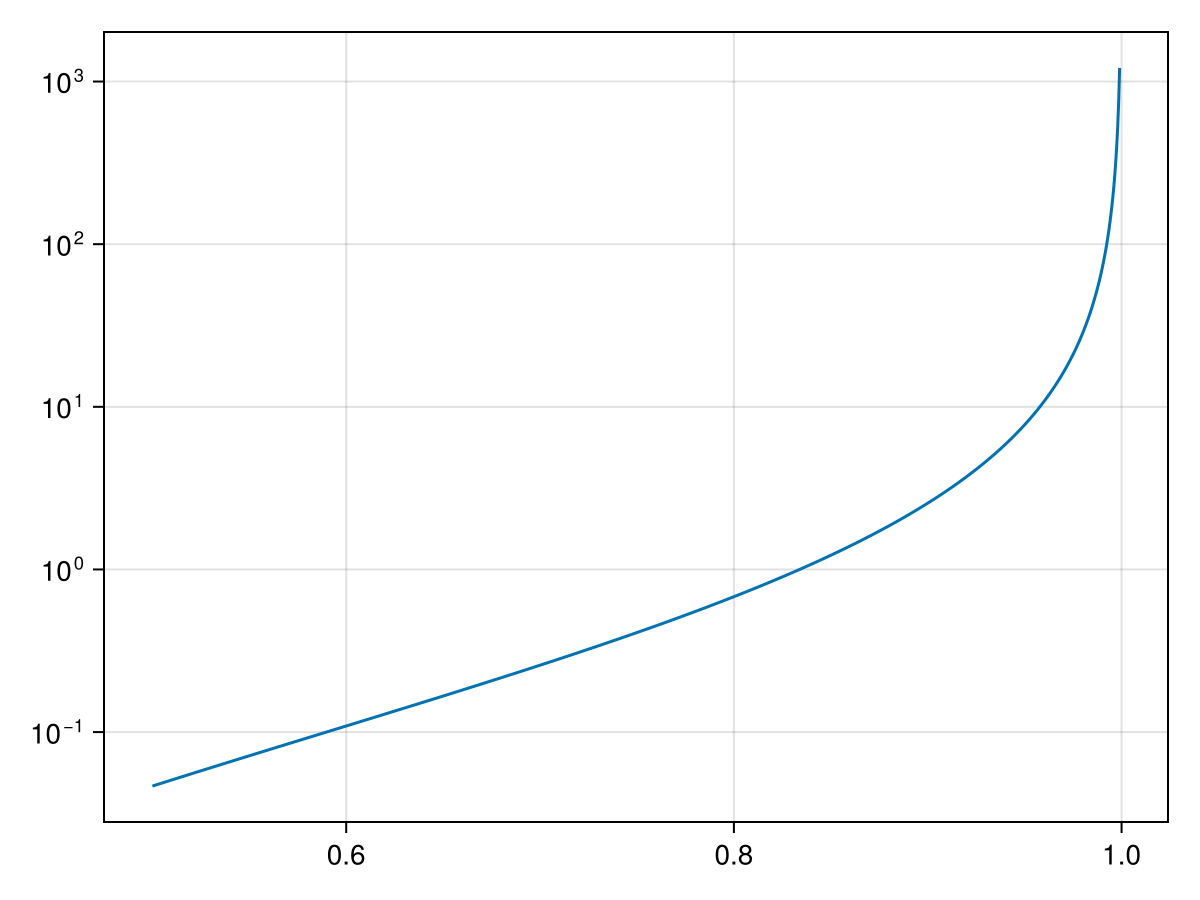

In [8]:
d = 7.0
arr = LinRange(0.5,0.999,1000)
println(arr)
hparr = calc_hydro_perm_cell(arr)/(d^2)
println(hparr[1])

f = Figure()
Axis(f[1, 1],yscale = log10)
lines!(arr, hparr)
f

In [15]:
"""
Creates an array of all monomer positions.
"""
function calc_rmon(c::MEDYAN.Context)
    rmon = SVector{3, Float64}[]
    for fil_id in filtype_fil_ids(c, 1)
        for mon_id in eachindex(fil_mon_states(c, 1, fil_id))
            name = MonomerName(1, fil_id, mon_id)
            push!(rmon,mon_position(c,name))
        end
    end
    return rmon
end

"""
Calculates the center of mass velocity of the network.
"""
function vel_com_cell(c,drmon,rmon_old)
    n_cell = MArray{Tuple{L^3},Int64}(zeros(L^3))
    dra_x_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    dra_y_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    dra_z_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        n_cell[cid] += 1
        dra_x_cell[cid] += view(drmon,i)[1][1]
        dra_y_cell[cid] += view(drmon,i)[1][2]
        dra_z_cell[cid] += view(drmon,i)[1][3]  
    end
    va_x_cell = dra_x_cell./n_cell
    va_y_cell = dra_y_cell./n_cell
    va_z_cell = dra_z_cell./n_cell
    return va_x_cell,va_y_cell,va_z_cell
end

"""
Calculates the porosity field.
"""
function calc_por_cell(c,rmon_old,lcell)
    #estimate actin monomer volume by assume it is a sphere with radius 3.5 nm
    actin_rad = 3.5
    actin_vol = (4/3)*π*(actin_rad^3)
    por_cell = MArray{Tuple{L^3},Float64}(zeros(L^3))
    #loop over all monomers accumulate array values, sort into cells using rmon_old
    for i in 1:size(rmon_old,1)
        cid = MEDYAN.grididat(c.grid, view(rmon_old,i)[1])
        por_cell[cid] += 1
    end
    por_cell *= actin_vol/(lcell^3)
    return por_cell
end

"""
Calculates the hydrolic permiability from porosity, using Gebart's formula.
"""
function calc_hydro_perm_cell(por_cell)
    #filament diameter in nm
    d = 7.0
    #fitting parameters
    ϕc = 0.0743 
    C1 = 0.491
    C2 = 2.31
    perm_cell = map(x -> (d^2)*C1*(sqrt((1-ϕc)/(1-x))-1)^C2,por_cell)
    #perm_cell = map(x -> (sqrt((1-ϕc)/(1-x))-1)^C2,por_cell)
    return perm_cell
end

calc_hydro_perm_cell